# SWE 599 - Human Pose Estimation 

This notebook shows the results of SWE 599 - Human Pose Estimation projects final output.
Aim was to analyze the pose of an office worker.
Notebook outputs 3 values.

Head left/right: Measures if your head is obligue towards your left or right arm.

Shoulder straight: Measures if both your shoulders are parallel to ground. 

Head up/down: Measures if your head is tilted towards your front or back.
 
Those 3 values are displayed either in green or red color. This is like a traffic light. Red means, bad posture whereas green means correct posture. 

This study is based on human-pose-estimation-0001 model from (https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001) and related OpenVino demo project.  

System benefits from OpenVino software, which helps to optimize the performance of various Intel based hardwares while working for calculation of deep learning models. 
More information can be found on: (https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html). 

There are 4 key values. 

System accepts an angle upto 5 degrees as a sign of straightness for the shoulders and head left/right. 

Head up/down is a little bit more complex. Hence this requires to make an estimation of 3rd dimension from a 2 dimension value. Here is, how it works. System calculates the distance between two eyes and also finds the two eyes' midpoint's coordinates. Than it is calculating the distance from this mid-point to tip of the nose. It is assumed that, if your head is up, and you are facing forward with an almost straight neck, those two values lengths are proportionally observed by web-cam. Almost always user's eyes are observed, if user is facing his/her laptop in the office. On the other hand, if user is not facing forward, but either down or up, due to 2D nature of the system, the distance from tip of the nose to eyes' midpoint becomes smaller or totally lost.  

For a smaller bracket use a smaller value, 0 means exact equality.

head_left_right_angle_max = 5 
left_shoulder_right_shoulder_angle_max = 5

For a smaller bracket, make those two values closer to each other.

nose_to_eye_min = 0.30
nose_to_eye_max = 0.40 -> Those two values are calibrated according to the laptop, in which the project is developed. Upcoming users, may need to re-calibrate those two values. But then, users will have the chance of getting a 3D feedback from a 2D system. 

## Imports

In [46]:
# C:\Users\eohta>openvino_env\Scripts\activate
# (openvino_env) C:\Users\eohta\openvino_notebooks>jupyter lab notebooks


import collections
import sys
import time
from pathlib import Path
import timeit

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
from openvino.runtime import Core

from decoder import OpenPoseDecoder

sys.path.append("../utils")
import notebook_utils as utils

## The model

Below section downloads the model from openvinotoolkit.
As precision. lowest possible is selected for demonstration. 
FP16 is half the size of FP32. Therefore, use half of the cache (vs FP32), memory bandwith, and half of your storage. 
OpenVino here uses model optimizer. Convolution layer generally uses the most computing power. 
By merging numerous convolutional layers, number of parameters were decreased.
To merge convolutional layers, the parameters of the merged one should be compatible with each other. 
In a convolutional layer, there are mainly 4 parameters.
Filters: Each filter is used to extract a different feature from the input. Therefore, the more the filters a model layer have, the more features learning possibility there is for the layer.

Kernel size: This is the size of kernel applied to input. Each filter has a size. This is a matrix. Can be square or rectangle. The smaller the size of the kernel, the smaller portion of the input is processed by this particular filter. 

Stride: This is the amount of pixels, that the filter moves at one step. 1 means, 1 pixel at a time. The bigger the stride size, the smaller the size of the output feature maps. 

Padding: Each step of convolutional network, decreases the size of the feature map. The decrease in the map size, is compensated by adding 0s.
If the matrix is a 5x5 size, and padding parameter is 1, then there will be two columns of 0s on the left and right, and two rows of 0s,on the top and bottom. So, a total of 7x7 matrix is created. But why? This helps to preserve the spatial orientation. Spatial orientation is important in the tasks like object detection and segmentation. 

For more information:

1-https://www.intel.com/content/www/us/en/developer/articles/technical/should-i-choose-fp16-or-fp32-for-my-deep-learning-model.html

2-https://www.sciencedirect.com/topics/engineering/convolutional-layer#:~:text=A%20convolutional%20layer%20is%20the%20main%20building%20block,with%20the%20image%20and%20creates%20an%20activation%20map.


In [47]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo.
model_name = "human-pose-estimation-0001"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16-INT8"

model_path = base_model_dir / "intel" / model_name / precision / f"{model_name}.xml"

if not model_path.exists():
    model_url_dir = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.1/models_bin/3/{model_name}/{precision}/"
    utils.download_file(model_url_dir + model_name + '.xml', model_path.name, model_path.parent)
    utils.download_file(model_url_dir + model_name + '.bin', model_path.with_suffix('.bin').name, model_path.parent)

### Load the model

Previously, model was downloaded.
Now, it is time to load. 
While loading the model, OpenVino started, system reads and understands the architecture of your system, and the weights. 
Four different models are supported. OpenVino IR, ONNX, PaddlePaddle and TensorFlow. OpenVino IR model uses two files to define the network.

The files needed for the weights: modelname.bin and modelname.xml
.bin file contains the weights and the biases of the model.
.xml file contains the topology of the model.

Downloaded models are located in a fixed structure, which indicates a vendor, the name of the model and a precision.

In [48]:
# Initialize OpenVINO Runtime
ie_core = Core()
# Read the network from a file.
model = ie_core.read_model(model_path)
# Let the AUTO device decide where to load the model (you can use CPU, GPU or MYRIAD as well).
compiled_model = ie_core.compile_model(model=model, device_name="AUTO", config={"PERFORMANCE_HINT": "LATENCY"})

# Get the input and output names of nodes.
input_layer = compiled_model.input(0)
output_layers = compiled_model.outputs

# Get the input size.
height, width = list(input_layer.shape)[2:]

Input layer has the name of the input node and output layers contain names of output nodes of the network. In the case of OpenPose Model, there is 1 input and 2 outputs: pafs and keypoints heatmap.

In [49]:
input_layer.any_name, [o.any_name for o in output_layers]

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

## Processing

### OpenPoseDecoder

This system works with decoder and encoder layers. Up to now, system has decoded. Now, it will be encoding. 
Decoding means distilling all the important parts of a given input. Encoder takes the input from decoder stage and a high quality output will be created. 
In our task, system defines the joints, limps and the person who owns the defined joint to correctly combine them with each other. 

Projects base model is OpenPose. Proposed system still uses OpenPose, but in an optimized way to work more efficiently with different hardwares.

How is OpenVino doing this? Here I want to give more detail about this rare case. Generally, research is done on using a single model, but in my case
due to lack of proper hardware, a second library (OpenVino) is also used. 

1-OpenVino is optimising the model. 
    a.Layer Fusion: Combining multiple layers into single layer. Remember lesser layers and bigger kernels.
    b.Precision Quantization: This was also previously mentioned. Using lower resolution like INT8 or FP16 will reduce memory usage.
    c.Weight sharing: This is done by giving the same weight to correalated layers.
2-OpenVino can provide hardware abstraction. 
    Without diving into hardware specific properties of OpenPose, OpenVino helps the user to use different hardware with same application programming interface (API).
3-Hardware specific optimizations.
    On top of OpenPose's general approach, OpenVino helps to use some Intel related hardware in more detail and efficiency.
4-Multi-Model Execution
    With the help of OpenVino, multiple models can work in parallel on the same hardware.

OpenVino project's owners provides a decoder for OpenPose, which is suitable with human-pose-estimation-0001 model.(https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/openvino/model_zoo/model_api/models/open_pose.py).



In [50]:
# Selection of OpenPose decoder.
decoder = OpenPoseDecoder()

### Process Results

Processing starts with 2D pooling. Heatmap contains various points with different probability. This is high resolution. To minimize the resolution,
most likely ones of those keypoints should be extracted. 
Pooling: Extracts the most likely keypoint locations.
Non-maximum suppression: Only returns the maximum value in a given neighbourhood.
After these two steps, decoder decodes the keypoints.

Function starts with padding, then calculates the shape of output by using stride. Creates a new array A_w.
The two arrays of A and A_w are multiplied and non-maximum ones are suppressed and set to 0.

Finally, please remember that results are smaller in size. A scaling factor is used to re-size the output with the same 
size of input.

In [51]:
# 2D pooling in numpy (from: https://stackoverflow.com/a/54966908/1624463)
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    """
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    A = np.pad(A, padding, mode="constant")

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides
    )
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling.
    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


# non maximum suppression
def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


# Get poses from results.
def process_results(img, pafs, heatmaps):
    # This processing comes from
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/models/open_pose.py
    pooled_heatmaps = np.array(
        [[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]]
    )
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    # Decode poses.
    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = list(compiled_model.output(index=0).partial_shape)
    output_scale = img.shape[1] / output_shape[3].get_length(), img.shape[0] / output_shape[2].get_length()
    # Multiply coordinates by a scaling factor.
    poses[:, :, :2] *= output_scale
    return poses, scores

### Draw Pose Overlays

System first requests a copy of the image.
Then takes the x,y coordinates and confidence interval of key points.
Draws joints and lips.
Calculates the posture correctness for head and shoulders.
Those two values are printed in green or red depending on the threshold values provided by user.
The below code is based on human_pose_estimation_demo, on top calculations for posture added.
See the repository from (https://github.com/openvinotoolkit/open_model_zoo/tree/master/demos/human_pose_estimation_demo/python).

Please follow-up the comments in the code. I prepared them line by line to follow-up easily. 
System is designed for 2D pose estimation(x and y axises). But with a special method, my project is comparing the two two dimensional values, to calculate the heads angle in z axis.
With current laptop configuration this system works properly.
In the installations for different laptops or desktops, nose_to_eye_min and nose_to_eye_max values might be updated by users.
The two values are located towards the end of this code block.

In [52]:
# Define 17 colors for 17 keypoints.
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

# Define skeleton (pairs of keypoints).
default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))

# Main function receives the image and returns the poses drawn on it.
def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img
    # Copy the image for drawing.
    img_limbs = np.copy(img)
     

    for pose in poses:
        # print (pose)
        # Take all the colomns, and the first two rows. Convert them to int32 to use as pixel coordinates.
        points = pose[:, :2].astype(np.int32)
        # Take the third row for scores of the keypoints.
        points_scores = pose[:, 2]
        # Draw joints if confidence point is greater than threshold.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    # Blend the original image and the image with the limbs (with some transparency).
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)

    
    # Calculate the angle between left eye and right eye.
   
    left_eye = pose[1]
    right_eye = pose[2]
    left_eye_right_eye = left_eye - right_eye
    left_eye_right_eye = np.arctan2(left_eye_right_eye[1], left_eye_right_eye[0])
    left_eye_right_eye = np.degrees(left_eye_right_eye)
    left_eye_right_eye = np.abs(left_eye_right_eye)
     
    # Print the calculated angle.
    # If the angle is between 0 and 5, print the "head left/right" title in green' otherwise, print it in red.
    head_left_right_angle_max = 5
    cv2.putText(img, str(left_eye_right_eye), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    if left_eye_right_eye > head_left_right_angle_max:
        cv2.putText(img, "head left/right", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        cv2.putText(img, "head left/right", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
    
    # Calculate the angle between left shoulder and right shoulder.

    left_shoulder = pose[5]
    right_shoulder = pose[6]
    left_shoulder_right_shoulder = left_shoulder - right_shoulder
    left_shoulder_right_shoulder = np.arctan2(left_shoulder_right_shoulder[1], left_shoulder_right_shoulder[0])
    left_shoulder_right_shoulder = np.degrees(left_shoulder_right_shoulder)
    left_shoulder_right_shoulder = np.abs(left_shoulder_right_shoulder)

    # Print the calculated angle.
    # If the angle is between 0 and 5, print the "shoulder" title in green, otherwise, print it in red.
    left_shoulder_right_shoulder_angle_max = 5
    cv2.putText(img, str(left_shoulder_right_shoulder), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    if left_shoulder_right_shoulder > left_shoulder_right_shoulder_angle_max:
        cv2.putText(img, "shoulder straight", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        cv2.putText(img, "shoulder straight", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Calculte the coordinates of the mid point between the left and right eye. 
    # Calculate the distance between the nose, and the midpoint of the left eye and the right eye.
    left_eye = pose[1]
    right_eye = pose[2]
    # calculate the midpoint's coordinates between the left and right eyes
    mid_point = (left_eye + right_eye) / 2
    # calculate the distance between the tip of the nose and the midpoint of the left and right eyes
    nose_distance = np.linalg.norm(pose[0] - mid_point)
    # Calculate the distance between the left eye and the right eye.
    eye_distance = np.linalg.norm(left_eye - right_eye)
    # Calculate the distance between two eyes, and compare with the distance of midpoint to nose.
    nose_to_eye_min = 0.30
    nose_to_eye_max = 0.40
    # To easily calculate those two ratios, one can set the value of calculation, i.e. set_up_mode = True.
    # Then system will output the eye_distance and nose_distance and the ratio of those two. 
    # The ratio of those two, with a bracket of flexibility, can be entered above.

    set_up_mode = True

    if set_up_mode:
        nose_to_eye_ratio = nose_distance / eye_distance
        cv2.putText(img, str(eye_distance), (400, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(img, str(nose_distance), (400, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(img, "eye_distance", (400, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(img, "nose_distance", (400, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(img, "nose_to_eye_ratio", (400, 210), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(img, str(nose_to_eye_ratio), (400, 270), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        
    nose_to_eye_current = (nose_distance / eye_distance) - ((nose_to_eye_min + nose_to_eye_max) / 2)

    if len(poses) > 0:
        cv2.putText(img, str(nose_to_eye_current), (400, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        if nose_distance > (eye_distance * nose_to_eye_min) or nose_distance < (eye_distance * nose_to_eye_max):
            cv2.putText(img, "head up/down", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        if nose_distance < (eye_distance * nose_to_eye_min) or nose_distance > (eye_distance * nose_to_eye_max):
            cv2.putText(img, "head up/down", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
     

    return img

### Main Processing Function

Run pose estimation on the specified source. Either a webcam or a video file.

In [53]:
# Main processing function to run pose estimation.
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    # Create a pipeline.
    pafs_output_key = compiled_model.output("Mconv7_stage2_L1")

    heatmaps_output_key = compiled_model.output("Mconv7_stage2_L2")
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()

        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # Resize the image and change dims to fit neural network input.
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # Create a batch of images (size = 1).
            input_img = input_img.transpose((2,0,1))[np.newaxis, ...]

            # Measure processing time.
            start_time = time.time()
            # Get results.
            results = compiled_model([input_img])
            stop_time = time.time()

            pafs = results[pafs_output_key]
            heatmaps = results[heatmaps_output_key]
            # Get poses from network results.
            poses, scores = process_results(frame, pafs, heatmaps)
                   
            # Draw poses on a frame.
            frame = draw_poses(frame, poses, 0.1)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
                               
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted by user - Thank you for using")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Pose Estimation

To use laptop camera `source=0` should be selected. Set `flip=True` when using a front-facing camera. In case of flickering, set `use_popup=True`.

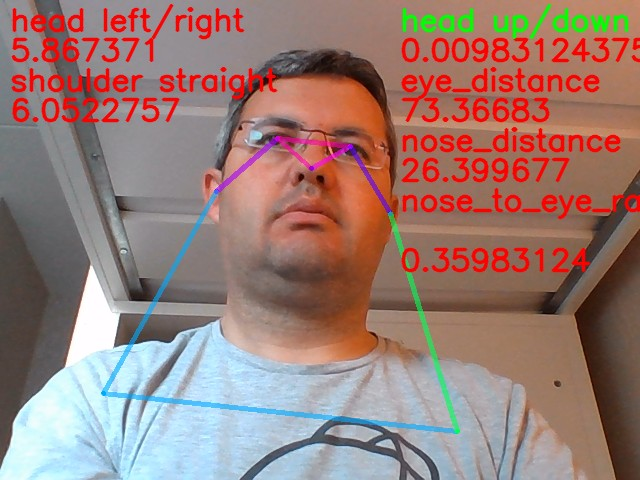

Interrupted by user - Thank you for using


In [54]:
run_pose_estimation(source=0, flip=True, use_popup=False)